In [1]:
import pandas as pd
import numpy as np

#for Label Encoding
from sklearn.preprocessing import LabelEncoder

#for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for Data splitting
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
import configparser
import requests
import json

from urllib import parse
from dns import resolver, reversename
from datetime import datetime
from bs4 import BeautifulSoup
from rblwatch import RBLSearch
import re
import whois
import ipaddress
import requests

# Data Loading

##### 50% - 50% : legitimate links - Malicious links

In [3]:
# Dataset from kaggle (https://www.kaggle.com/shashwatwork/web-page-phishing-detection-dataset)
# 50% - 50% : legitimate URLs - Malicious URLs

df = pd.read_csv(r'C:\Users\Acer\Desktop\Major Project\7th Sem\Machine Learning Models\Dataset\dataset_phishing.csv')
df.shape

(11430, 89)

# Pre-processing

##### Dropping duplicate values in dataset

In [4]:
df=df.drop_duplicates(keep='first')

##### Dropping useless columns

In [5]:
df.drop(df.columns.difference(['url','status']), 1, inplace=True)
df

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
...,...,...
11425,http://www.fontspace.com/category/blackletter,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,phishing
11427,https://www.facebook.com/Interactive-Televisio...,legitimate
11428,http://www.mypublicdomainpictures.com/,legitimate


##### Encoding status column

In [6]:
status_encoder = LabelEncoder()

status_encoder.fit(df['status'])
df['status_enc'] = status_encoder.transform(df['status'])

df.drop(['status'],axis =1,inplace=True)

# Features Extraction from dataframe

## LEXICAL BASED FEATURES

In [7]:
def count_length(url): # 1.counting length of URL 
    #Bucket size : 37 in accordance http://www.supermind.org/blog/740/average-length-of-a-url-part-2
    if len(url)<=37:
        return 0
#     elif len(url)>=38 and len(url)<=74:
#         return 1
    else:
        return 1
    
def count_dots(url): # 2.counting dots in URL
    dot_count = url.count('.')
    return dot_count

def count_slash(url): # 3.counting slash in URL
    slash_count = url.count('/')
    return slash_count

def count_hyphen(url): # 4.counting hyphen in URL
    hyphen_count = url.count('-')
    return hyphen_count

def count_at(url): # 5.counting @ in URL
    at_count = url.count('@')
    return at_count

def count_underline(url): # 6.counting underline in URL
    underline_count = url.count('_')
    return underline_count

def count_plus(url): # 7.counting + in URL
    plus_count = url.count('+')
    return plus_count

def count_hashtag(url): # 8.counting # in URL
    hashtag_count = url.count('#')
    return hashtag_count

def count_digits(url): # 9.counting digits present in URL
    digit_count = 0
    for i in url:
        if i.isdigit():
            digit_count=digit_count+1
    return digit_count

def count_special(url): #10. counting special characters present in URL
    special=0
    for i in url:
        if(url.isalpha()==0 and url.isdigit()==0):
            special = special + 1
    return special

def count_percentage(url): # 11.counting % in URL
    percentage_count = url.count('%')
    return percentage_count 

def count_equal(url): # 12.counting = in URL
    equal_count = url.count('=')
    return equal_count   

def count_and(url): # 13.counting & in URL
    and_count = url.count('&')
    return and_count

In [8]:
def lexicalFeatureExtraction(url,label):
    lexical_features = []
    
    #Lexical Features
    lexical_features.append(count_length(url)) #1
    lexical_features.append(count_dots(url)) #2
    lexical_features.append(count_slash(url)) #3
    lexical_features.append(count_hyphen(url)) #4
    lexical_features.append(count_at(url)) #5
    lexical_features.append(count_underline(url)) #6
    lexical_features.append(count_plus(url)) #7
    lexical_features.append(count_hashtag(url)) #8
    lexical_features.append(count_digits(url)) #9
    lexical_features.append(count_special(url)) #10
    lexical_features.append(count_percentage(url)) #11
    lexical_features.append(count_equal(url)) #12
    lexical_features.append(count_and(url)) #13
    
    return lexical_features

In [9]:
featuresLexical = []
label = 0

for i in range(0, 11430):
    url_value = df['url'][i]
    featuresLexical.append(lexicalFeatureExtraction(url_value,label))
    
lexical_labels = ['url_length','url_dot', 'url_slash', 'url_hyphen', 'url_at', 'url_underline','url_plus','url_hashtag', 
                  'url_digits', 'url_special', 'url_percent', 'url_equal', 'url_and']

lexical_df = pd.DataFrame(featuresLexical, columns=lexical_labels)
lexical_df.head()

,url_length,url_dot,url_slash,url_hyphen,url_at,url_underline,url_plus,url_hashtag,url_digits,url_special,url_percent,url_equal,url_and
0,0,3,3,0,0,0,0,0,0,37,0,0,0
1,1,1,5,0,0,0,0,0,17,77,0,0,0
2,1,4,5,1,0,2,0,0,19,126,0,3,2
3,0,2,2,0,0,0,0,0,0,18,0,0,0
4,1,2,5,2,0,0,0,0,0,55,0,0,0


## DOMAIN BASED FEATURES

In [10]:
from urllib.parse import urlparse
from tldextract import extract
import tldextract
import re

In [11]:
def domain_length(url): # 1.Domain Length
    # Average length of domain according to (https://datagenetics.com/blog/march22012/) is 12
    domain = urlparse(url).netloc
    if len(domain)<=8:
        return 0
    elif len(domain)>=9 and len(domain)<=16:
        return 1
    elif len(domain)>=17 and len(domain)<=24:
        return 2
    else:
        return 3
    
common_subdomains = {'www','mail','blog','webmail','server','ns1','ns2','smtp','secure','vpn','m','shop','ftp','mail2','test','portal','ns','ww1','host','support','dev','web','bbs','ww42','mx','email','cloud','1','mail1','2','forum','owa','www2','gw','admin','store','mx1','cdn','api','exchange','app','gov','2tty','vps','govyty','hgfgdf','news','1rer','lkjkui'} 
# top 50 subdomains (https://bitquark.co.uk/blog/2016/02/29/the_most_popular_subdomains_on_the_internet)

def domain_subdomain(url): # 2.extracting subdomain
    subdomain = tldextract.extract(url).subdomain
    if subdomain in common_subdomains:
        return 0
    else:
        return 1

phishing_tlds = { 'cyou','top','cam','sbs','rest','bar','ba','xyz','shop','cn','bd','support','quest','casa','ink','th','link','ng','pk','buzz','trade','best','digital','monster','id','su','store','ke','np','tr','one','live','cc','tn','vn','fun','club','work','icu','space','site','fit'}
# top phishing top level domains : Cybercrime on Top Level Domains (https://trends.netcraft.com/cybercrime/tlds)

def domain_top(url): # 3.Top Level Domain
    tsd, td, tsu = extract(url) # gets subdomain, domain, tld
    if tsu in phishing_tlds:
        return 1
    else:
        return 0

def domain_port(url): # 4.Port number
    port = urlparse(url).port
    return port 


# import socket
# import ipaddress
# from ipaddress import IPv4Address, IPv4Network
# from ipaddress import IPv6Address, IPv6Network
# def ip_class(url): #5
#     try:
# #         ips = socket.getaddrinfo(urlparse(url).netloc, '8080')
#         ips = ipaddress.ip_address(urlparse(url).netloc)
#         if isinstance(ips, ipaddress.IPv4Address):
#             cl_A = IPv4Network(("10.0.0.0", "255.0.0.0"))  # or IPv4Network("10.0.0.0/8")
#             cl_B = IPv4Network(("172.16.0.0", "255.240.0.0"))  # or IPv4Network("172.16.0.0/12")
#             cl_C = IPv4Network(("192.168.0.0", "255.255.0.0"))  # or IPv4Network("192.168.0.0/16")
#             if ips in cl_A:
#                 return 1
#             elif ips in cl_B:
#                 return 2
#             elif ips in cl_C:
#                 return 3
#         elif isinstance(ips, ipaddress.IPv6Address):   
#             cla_A = IPv6Network(("10.0.0.0", "255.0.0.0"))  # or IPv4Network("10.0.0.0/8")
#             cla_B = IPv6Network(("172.16.0.0", "255.240.0.0"))  # or IPv4Network("172.16.0.0/12")
#             cla_C = IPv6Network(("192.168.0.0", "255.255.0.0"))  # or IPv4Network("192.168.0.0/16")
#             if ips in cla_A:
#                 return 1
#             elif ips in cla_B:
#                 return 2
#             elif ips in cla_C:
#                 return 3
#     except ValueError:
#         return 9

    
    
def domain_digits(url):  # 6
    domain = urlparse(url).netloc
    domainDigit_count = 0
    for i in url:
        if i.isdigit():
            domainDigit_count=domainDigit_count+1
    return domainDigit_count
    

# def domain_age(url):  # 7
#     whois_result = whois.whois(url)
#     if(whois_result!=False):
#         created_date = whois_result.creation_date
#         if((created_date is not None) and (type(created_date)!=str)):
#             if(type(created_date)==list):
#                 created_date=created_date[0]
#             today_date=datetime.datetime.now()
#             days = (today_date-created_date).days
#             return days
#         else:
#             return -1
#     else:
#         return -1

#8

def domain_scheme(url): # 9.extracting scheme of URL
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 0
    else:
        return 1
    
def domain_dots(url):  # 10
    domain = urlparse(url).netloc
    domainDots_count = domain.count('.')
    return domainDots_count

#11
#12
#13

def domain_vowels(url):  # 14
    domain = urlparse(url).netloc
    vowels=0
    for i in domain:
          if(i=='a' or i=='e' or i=='i' or i=='o' or i=='u' or i=='A' or i=='E' or i=='I' or i=='O' or i=='U'):
                vowels=vowels+1
    return vowels

# def domain_percentage(url):  # 15
#     domain = urlparse(url).netloc
#     percentage_domain = domain.count('%')
#     return percentage_domain
# 
# def domain_equal(url):  # 18
#     domain = urlparse(url).netloc
#     equal_domain = domain.count('=')
#     return equal_domain

In [12]:
# import requests
# def domain_status(url):
#     r = requests.head(url, allow_redirects=True)
#     return r.status_code

In [13]:
def domainFeatureExtraction(url,label):
    domain_features = []
    
    #Domain Features
    domain_features.append(domain_length(url)) #1
    domain_features.append(domain_subdomain(url)) #2
    domain_features.append(domain_top(url)) #3
    domain_features.append(domain_port(url)) #4
#     domain_features.append(ip_class(url)) #5
    domain_features.append(domain_digits(url)) #6
#     domain_features.append(domain_age(url)) #7
    domain_features.append(domain_scheme(url)) #9
    domain_features.append(domain_dots(url)) #10
    domain_features.append(domain_vowels(url)) #14
#     domain_features.append(domain_percentage(url)) #15
#     domain_features.append(domain_equal(url)) #18
#     domain_features.append(domain_status(url)) #19
    
    
    return domain_features

In [14]:
featuresDomain = []
label = 0

for i in range(0, 11430):
    url_value = df['url'][i]
    featuresDomain.append(domainFeatureExtraction(url_value,label))
    
domain_labels = ['domain_length', 'domain_sub', 'domain_top', 
                'domain_port',    'domain_digits',
                    'domain_scheme', 'domain_dots',
                 'domain_vowels']

domain_df = pd.DataFrame(featuresDomain, columns=domain_labels)
domain_df.head()

,domain_length,domain_sub,domain_top,domain_port,domain_digits,domain_scheme,domain_dots,domain_vowels
0,2,0,0,NaN,0,1,2,5
1,2,1,0,NaN,17,1,1,8
2,3,1,0,NaN,19,0,4,17
3,1,1,0,NaN,0,1,2,3
4,1,0,0,NaN,0,1,2,4


In [15]:
# daf.domain_vowels.unique()

## DIRECTORY/PARAMETERS BASED FEATURES

In [16]:
def dir_presence(url): # 1.presence of directory
    if urlparse(url).path:
        return 1
    else:
        return 0
    
def dir_length(url):  # 2.length of directory
    path=urlparse(url).path
    count=0
    for i in path:
        if i=='/':
            count=count+1
    return count

import os
def dir_filetype(url): # 3.filetype of directory
    path=urlparse(url).path
    extension = os.path.splitext(path)[1]
    if extension==".php":
        return 1
    elif extension==".html" or extension==".htm" or extension==".rhtml" or extension==".phtml" or extension==".shtml":
        return 2
    elif extension==".doc":
        return 3
    elif extension==".exe":
        return 4
    elif extension==".js":
        return 5
    else:
        return 0

def dir_ftLength(url): # 3.filetype length
    path=urlparse(url).path
    extension = os.path.splitext(path)[1]
    if len(extension)<=3:
        return 1
    elif len(extension)>=3 and len(extension)<=8:
        return 2
    else:
        return 0    

def query_presence(url): # 4.presence of query. eg: cmd=_update&dispatch=89e6a3b4b063b8d1b&locale=_
    if urlparse(url).query:
        return 1
    else:
        return 0
    
def query_length(url): # 5.length of query string.
    if len(urlparse(url).query)<10:
        return 0
    elif len(urlparse(url).query)>=11 and len(urlparse(url).query)<=20:
        return 1
    elif len(urlparse(url).query)>=21 and len(urlparse(url).query)<=30:
        return 2
    else:
        return 3

    
def prefixSuffix(url):
    if '-' in urlparse(url).netloc:
        return 0            
    else:
        return 1           

In [17]:
def directoryFeatureExtraction(url,label):
    directory_features = []
    
    #Directory Features
    directory_features.append(dir_presence(url)) #1
    directory_features.append(dir_length(url)) #2
    directory_features.append(dir_filetype(url)) #3
    directory_features.append(dir_ftLength(url)) #4
    directory_features.append(query_presence(url)) #5
    directory_features.append(query_length(url)) #6
    directory_features.append(prefixSuffix(url)) #6
    
    return directory_features

In [18]:
featuresDirectory = []
label = 0

for i in range(0, 11430):
    url_value = df['url'][i]
    featuresDirectory.append(directoryFeatureExtraction(url_value,label))
    
directory_labels = ['dir_presence', 'dir_length', 'dir_filetype','filetype_length', 'query_presence', 'query_length', 'prefix_suffix']

directory_df = pd.DataFrame(featuresDirectory, columns=directory_labels)
directory_df.head()

,dir_presence,dir_length,dir_filetype,filetype_length,query_presence,query_length,prefix_suffix
0,1,1,1,2,0,0,1
1,1,3,0,1,0,0,1
2,1,3,0,1,1,3,0
3,0,0,0,1,0,0,1
4,1,3,0,1,0,0,1


## ABNORMAL BASED FEATURES

In [19]:
shortening_services = r"bit\.ly|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|kl\.am|wp\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|qr\.net|1url\.com|tweez\.me|v\.gd|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|filoops\.info|vzturl\.com|" \
                      r"tr\.im|link\.zip\.net"
def url_short(url):
    match=re.search(shortening_services,url)
    if match:
        return 1
    else:
        return 0

# import socket
# def havingIP(url):
#     domain = urlparse(url).netloc
#     ip=socket.gethostbyname(domain)
#     return ip

# import whois

# def domain_age(url):  # 7
#     domain = urlparse(url).netloc
#     whois_result = whois.whois(domain)
#     try:
#         if(whois_result!=False):
#             created_date = whois_result.creation_date
#             return created_date
#             if((created_date is not None) and (type(created_date)!=str)):
#                 if(type(created_date)==list):
#                     created_date=created_date[0]
#                 today_date=datetime.datetime.now()
#                 days = (today_date-created_date).days
#                 return days

#             else:
#                 return -1
#     except whois.parser.PywhoisError:
#         return -1


# import urllib
# from bs4 import BeautifulSoup
# def web_traffic(url):
#     try:
#     #Filling the whitespaces in the URL if any
#         url = urllib.parse.quote(url)
#         rank = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url).read(), "lxml").find(
#             "REACH")['RANK']
#         rank = int(rank)
#     except TypeError:
#         return 1
#     if rank <100000:
#         return 1
#     else:
#         return 0

In [20]:
def abnormalFeatureExtraction(url,label):
    abnormal_features = []
    
    #Directory Features
    abnormal_features.append(url_short(url)) #1
#     abnormal_features.append(web_traffic(url)) #2
    
    return abnormal_features

In [21]:
featuresAbnormal = []
label = 0

for i in range(0, 11430):
    url_value = df['url'][i]
    featuresAbnormal.append(abnormalFeatureExtraction(url_value,label))
    
abnormal_labels = ['short_url']#, 'traffic']

abnormal_df = pd.DataFrame(featuresAbnormal, columns=abnormal_labels)
abnormal_df.head()

,short_url
0,0
1,0
2,0
3,0
4,0


In [22]:
# import socket
# # print (socket.gethostbyname('google.com'))
# print (whois.whois('google.com'))
# pip install lxml

In [23]:
import dns
import dns.resolver

result = dns.resolver.query('google.com', 'A')
print (result)

### Concatening features with main dataframe

In [24]:
daf = pd.concat([df, lexical_df], axis=1)
daf = pd.concat([daf, domain_df], axis=1)
daf = pd.concat([daf, directory_df], axis=1)
daf = pd.concat([daf, abnormal_df], axis=1)

In [25]:
# daf.dir_filetype.unique()

In [26]:
daf.head()

,url,status_enc,url_length,url_dot,url_slash,url_hyphen,url_at,url_underline,url_plus,url_hashtag,...,domain_dots,domain_vowels,dir_presence,dir_length,dir_filetype,filetype_length,query_presence,query_length,prefix_suffix,short_url
0,http://www.crestonwood.com/router.php,0,0,3,3,0,0,0,0,0,...,2,5,1,1,1,2,0,0,1,0
1,http://shadetreetechnology.com/V4/validation/a...,1,1,1,5,0,0,0,0,0,...,1,8,1,3,0,1,0,0,1,0
2,https://support-appleld.com.secureupdate.duila...,1,1,4,5,1,0,2,0,0,...,4,17,1,3,0,1,1,3,0,0
3,http://rgipt.ac.in,0,0,2,2,0,0,0,0,0,...,2,3,0,0,0,1,0,0,1,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,2,5,2,0,0,0,0,...,2,4,1,3,0,1,0,0,1,0


In [27]:
daf=daf.replace(np.nan, 0)
daf['domain_port']=daf['domain_port'].astype(int)

In [28]:
daf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11430 entries, 0 to 11429
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              11430 non-null  object
 1   status_enc       11430 non-null  int32 
 2   url_length       11430 non-null  int64 
 3   url_dot          11430 non-null  int64 
 4   url_slash        11430 non-null  int64 
 5   url_hyphen       11430 non-null  int64 
 6   url_at           11430 non-null  int64 
 7   url_underline    11430 non-null  int64 
 8   url_plus         11430 non-null  int64 
 9   url_hashtag      11430 non-null  int64 
 10  url_digits       11430 non-null  int64 
 11  url_special      11430 non-null  int64 
 12  url_percent      11430 non-null  int64 
 13  url_equal        11430 non-null  int64 
 14  url_and          11430 non-null  int64 
 15  domain_length    11430 non-null  int64 
 16  domain_sub       11430 non-null  int64 
 17  domain_top       11430 non-null

##### Encoding URLs to integer datatype

In [29]:
daf.drop(['url'],axis =1,inplace=True)

# Dataframe splitting

In [30]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [31]:
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
np.random.seed(8)
%matplotlib inline

In [32]:
def generate_accuracy_and_heatmap(model, x, y):
    cm = confusion_matrix(y,model.predict(x))
    sns.heatmap(cm,annot=True,fmt="d")
    ac = accuracy_score(y,model.predict(x))
    f_score = f1_score(y,model.predict(x))
    print('Accuracy is: ', ac)
    print('F1 score is: ', f_score)
    print ("\n")
    print (pd.crosstab(pd.Series(model.predict(x), name='Predicted'),
                       pd.Series(y['status_enc'],name='Actual')))
    return 1

In [33]:
numerical_feature_columns = list(daf._get_numeric_data().columns)
numerical_feature_columns

['status_enc',
 'url_length',
 'url_dot',
 'url_slash',
 'url_hyphen',
 'url_at',
 'url_underline',
 'url_plus',
 'url_hashtag',
 'url_digits',
 'url_special',
 'url_percent',
 'url_equal',
 'url_and',
 'domain_length',
 'domain_sub',
 'domain_top',
 'domain_port',
 'domain_digits',
 'domain_scheme',
 'domain_dots',
 'domain_vowels',
 'dir_presence',
 'dir_length',
 'dir_filetype',
 'filetype_length',
 'query_presence',
 'query_length',
 'prefix_suffix',
 'short_url']

In [34]:
target = 'status_enc'

<AxesSubplot:>

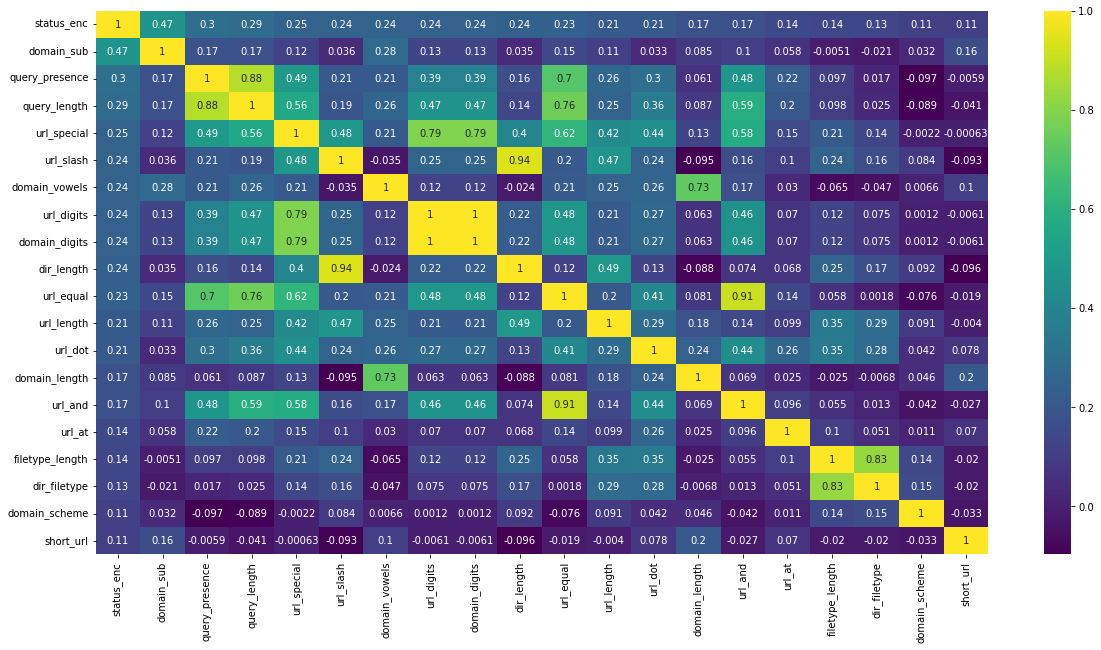

In [35]:
k = 20 #number of variables for heatmap
cols = daf[numerical_feature_columns].corr().nlargest(k, target)[target].index
cm = daf[cols].corr()
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [36]:
X = daf.loc[:, daf.columns != target]
Y = daf.loc[:, daf.columns == target]

In [37]:
X.shape

(11430, 29)

In [38]:
Y.shape

(11430, 1)

In [39]:
# Y = df['status_enc']
# X = daf.drop('status_enc',axis=1)
# X.shape, Y.shape

In [40]:
X

,url_length,url_dot,url_slash,url_hyphen,url_at,url_underline,url_plus,url_hashtag,url_digits,url_special,...,domain_dots,domain_vowels,dir_presence,dir_length,dir_filetype,filetype_length,query_presence,query_length,prefix_suffix,short_url
0,0,3,3,0,0,0,0,0,0,37,...,2,5,1,1,1,2,0,0,1,0
1,1,1,5,0,0,0,0,0,17,77,...,1,8,1,3,0,1,0,0,1,0
2,1,4,5,1,0,2,0,0,19,126,...,4,17,1,3,0,1,1,3,0,0
3,0,2,2,0,0,0,0,0,0,18,...,2,3,0,0,0,1,0,0,1,0
4,1,2,5,2,0,0,0,0,0,55,...,2,4,1,3,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,1,2,4,0,0,0,0,0,0,45,...,2,4,1,2,0,1,0,0,1,0
11426,1,5,5,0,1,0,0,0,2,84,...,2,4,1,3,1,2,1,2,1,0
11427,1,2,5,6,0,1,0,0,15,105,...,2,5,1,3,0,1,1,1,1,0
11428,1,2,3,0,0,0,0,0,0,38,...,2,9,1,1,0,1,0,0,1,0


In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0 , shuffle = False)

In [42]:
X_train

,url_length,url_dot,url_slash,url_hyphen,url_at,url_underline,url_plus,url_hashtag,url_digits,url_special,...,domain_dots,domain_vowels,dir_presence,dir_length,dir_filetype,filetype_length,query_presence,query_length,prefix_suffix,short_url
0,0,3,3,0,0,0,0,0,0,37,...,2,5,1,1,1,2,0,0,1,0
1,1,1,5,0,0,0,0,0,17,77,...,1,8,1,3,0,1,0,0,1,0
2,1,4,5,1,0,2,0,0,19,126,...,4,17,1,3,0,1,1,3,0,0
3,0,2,2,0,0,0,0,0,0,18,...,2,3,0,0,0,1,0,0,1,0
4,1,2,5,2,0,0,0,0,0,55,...,2,4,1,3,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9139,0,1,3,0,0,0,0,0,0,29,...,1,5,1,1,0,1,0,0,1,0
9140,0,2,3,0,0,0,0,0,0,32,...,2,9,1,1,0,1,0,0,1,0
9141,0,2,3,0,0,0,0,0,0,35,...,1,4,1,1,0,2,0,0,1,1
9142,1,3,5,0,0,3,0,0,0,78,...,2,6,1,3,2,2,0,0,1,0


In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

classifier = DecisionTreeClassifier(random_state=0 , max_depth=18)

classifier.fit(X_train, Y_train)

Y_predict = classifier.predict(X_test)

Accuracy is:  0.8547681539807525
F1 score is:  0.8500451671183379


Empty DataFrame
Columns: []
Index: []


1

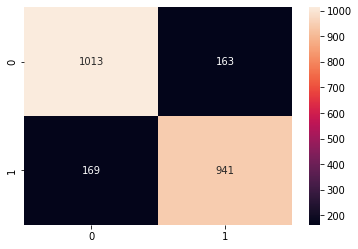

In [44]:
# clf = classifier.fit(X_train, Y_train)
# tree.plot_tree(clf)
generate_accuracy_and_heatmap(classifier, X_test, Y_test)

# FEATURE SELECTION

In [45]:
select_feature = SelectKBest(chi2, k=28).fit(X_train, Y_train)

In [46]:
selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                     'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
16,domain_port,30933.814
9,url_special,27824.225
8,url_digits,25272.287
17,domain_digits,25272.287
26,query_length,1821.609
11,url_equal,1607.102
20,domain_vowels,1063.936
12,url_and,1010.846
14,domain_sub,894.345
22,dir_length,719.219


In [47]:
X_train_chi = select_feature.transform(X_train)
X_test_chi = select_feature.transform(X_test)

In [48]:
X_train.head(3)

,url_length,url_dot,url_slash,url_hyphen,url_at,url_underline,url_plus,url_hashtag,url_digits,url_special,...,domain_dots,domain_vowels,dir_presence,dir_length,dir_filetype,filetype_length,query_presence,query_length,prefix_suffix,short_url
0,0,3,3,0,0,0,0,0,0,37,...,2,5,1,1,1,2,0,0,1,0
1,1,1,5,0,0,0,0,0,17,77,...,1,8,1,3,0,1,0,0,1,0
2,1,4,5,1,0,2,0,0,19,126,...,4,17,1,3,0,1,1,3,0,0


In [49]:
X_train_chi

array([[0, 3, 3, ..., 0, 1, 0],
       [1, 1, 5, ..., 0, 1, 0],
       [1, 4, 5, ..., 3, 0, 0],
       ...,
       [0, 2, 3, ..., 0, 1, 1],
       [1, 3, 5, ..., 0, 1, 0],
       [0, 2, 3, ..., 0, 1, 0]], dtype=int64)

In [50]:
classifier.fit(X_train_chi, Y_train)

DecisionTreeClassifier(max_depth=18, random_state=0)

Accuracy is:  0.8547681539807525
F1 score is:  0.8507194244604317


Empty DataFrame
Columns: []
Index: []


1

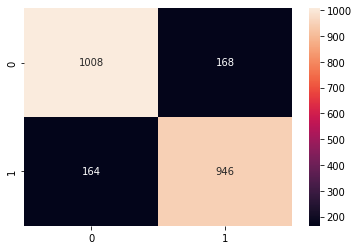

In [51]:
generate_accuracy_and_heatmap(classifier, X_test_chi, Y_test)

<AxesSubplot:>

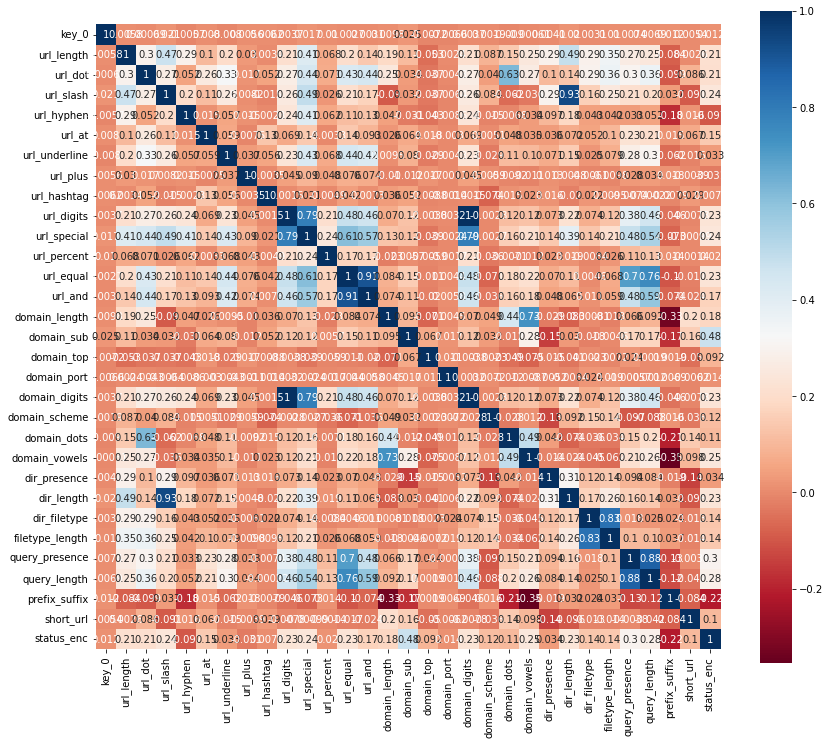

In [52]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('', y=2, size=15)
sns.heatmap(X_train.merge(Y_train , on = X_train.index ).corr(), 
            square=True, cmap=colormap, linecolor='white', annot=True)

# Model Training

## Decision Tree Classifier

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# classifier_DT = DecisionTreeClassifier(random_state=8 , max_depth=18)
classifier_DT=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=18,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0, 
                                     random_state=0, splitter='best')
classifier_DT.fit(X_train_chi, Y_train)

Y_predict = classifier_DT.predict(X_test_chi)

In [54]:
# clf = classifier.fit(X_train, Y_train)
# tree.plot_tree(clf)

Accuracy is:  0.8503937007874016
F1 score is:  0.8452488687782806


Empty DataFrame
Columns: []
Index: []


1

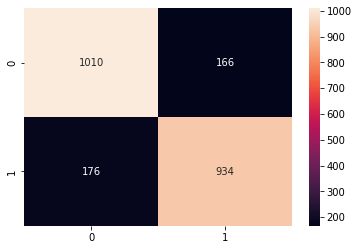

In [55]:
generate_accuracy_and_heatmap(classifier_DT, X_test_chi, Y_test)

In [56]:
from sklearn.metrics import accuracy_score

Y_test_tree = classifier_DT.predict(X_test_chi)
Y_train_tree = classifier_DT.predict(X_train_chi)

acc_train_tree = accuracy_score(Y_test_tree,Y_test)

print("Decision Tree Accuracy (training data) : ", acc_train_tree)

Decision Tree Accuracy (training data) :  0.8503937007874016


In [66]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report

# # confusion matrix
# matrix = confusion_matrix(Y_test,Y_test_tree, labels=[1,0])
# print('Confusion matrix : \n',matrix)

# # outcome values order in sklearn
# tp, fn, fp, tn = confusion_matrix(Y_test,Y_test_tree,labels=[1,0]).reshape(-1)
# print('Outcome values : \n', tp, fn, fp, tn)

# # classification report for precision, recall f1-score and accuracy
# matrix = classification_report(Y_test,Y_test_tree,labels=[1,0])
# print('Classification report : \n',matrix)

## Support Vector Machine

In [58]:
from sklearn import svm
clf_svm = svm.SVC()
clf_svm.fit(X_train_chi, Y_train)
clf_svm.predict(X_test_chi)

array([0, 0, 0, ..., 1, 0, 1])

Accuracy is:  0.6535433070866141
F1 score is:  0.5000000000000001


Empty DataFrame
Columns: []
Index: []


1

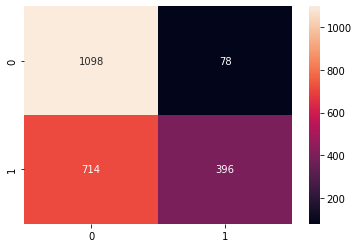

In [59]:
generate_accuracy_and_heatmap(clf_svm, X_test_chi, Y_test)

## Stochastic Gradient Descent

In [64]:
from sklearn.linear_model import SGDClassifier
clf_sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=3)
clf_sgd.fit(X_train_chi, Y_train)
SGDClassifier(max_iter=3)

SGDClassifier(max_iter=3)

Accuracy is:  0.7729658792650919
F1 score is:  0.7914825231016472


Empty DataFrame
Columns: []
Index: []


1

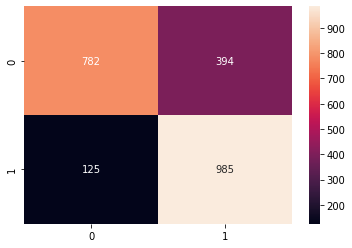

In [65]:
generate_accuracy_and_heatmap(clf_sgd, X_test_chi, Y_test)

### Gaussian Process Classification

In [67]:
from sklearn.gaussian_process import GaussianProcessClassifier

clf_gpc = GaussianProcessClassifier()
clf_gpc.fit(X_train_chi, Y_train)

GaussianProcessClassifier()

Accuracy is:  0.8307086614173228
F1 score is:  0.8235294117647058


Empty DataFrame
Columns: []
Index: []


1

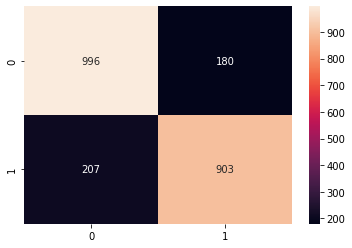

In [68]:
generate_accuracy_and_heatmap(clf_gpc, X_test_chi, Y_test)

## Multi-layer Perceptron

In [71]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier()

clf_mlp.fit(X_train_chi, Y_train)

MLPClassifier()

Accuracy is:  0.8547681539807525
F1 score is:  0.8530973451327434


Empty DataFrame
Columns: []
Index: []


1

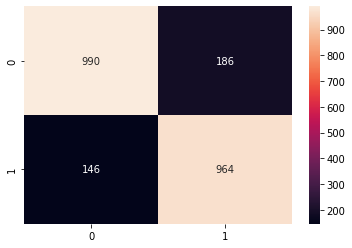

In [72]:
generate_accuracy_and_heatmap(clf_mlp, X_test_chi, Y_test)